In [1]:
import pandas as pd # data processing
import numpy as np # linear algebra

# data visualization

import matplotlib.pyplot as plt
import seaborn as sns

import timeit # time measure

import sys

print ('Python version ->', sys.version)
print ('Numpy version ->', np.__version__)
print ('Pandas version ->', pd.__version__)

%matplotlib inline

import matplotlib
import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname = './data/bus/AppleGothic.ttf').get_name()
matplotlib.rc('font', family = font_name)

import warnings
warnings.filterwarnings(action='ignore')

Python version -> 3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Numpy version -> 1.16.4
Pandas version -> 0.24.2


In [2]:
train = pd.read_csv("./data/bus/train.csv")
test = pd.read_csv("./data/bus/test.csv")
bts = pd.read_csv("./data/bus/bus_bts.csv")

In [4]:
print("train.csv. Shape: ",train.shape)
print("test.csv. Shape: ",test.shape)
print("bts.csv. Shape: ",bts.shape)

train.csv. Shape:  (415423, 21)
test.csv. Shape:  (228170, 20)
bts.csv. Shape:  (2409414, 13)


In [5]:
# 날짜 범위 비교
print(train['date'].agg(['min','max'])) 
print(test['date'].agg(['min','max'])) 
print(bts['geton_date'].agg(['min','max']))

min    2019-09-01
max    2019-09-30
Name: date, dtype: object
min    2019-10-01
max    2019-10-16
Name: date, dtype: object
min    2019-09-01
max    2019-10-16
Name: geton_date, dtype: object


* train : 2019-09-01 ~ 2019-09-30
* test : 2019-10-01 ~ 2019-10-16
* bts : 2019-09-01 ~ 2019-10-16

따라서 bts에는 train과 달리 9월 이후의 데이터도 있으므로 data leakage issue 조심할 것

In [6]:
train.isnull().sum()

id               0
date             0
bus_route_id     0
in_out           0
station_code     0
station_name     0
latitude         0
longitude        0
6~7_ride         0
7~8_ride         0
8~9_ride         0
9~10_ride        0
10~11_ride       0
11~12_ride       0
6~7_takeoff      0
7~8_takeoff      0
8~9_takeoff      0
9~10_takeoff     0
10~11_takeoff    0
11~12_takeoff    0
18~20_ride       0
dtype: int64

In [7]:
test.isnull().sum()

id               0
date             0
bus_route_id     0
in_out           0
station_code     0
station_name     0
latitude         0
longitude        0
6~7_ride         0
7~8_ride         0
8~9_ride         0
9~10_ride        0
10~11_ride       0
11~12_ride       0
6~7_takeoff      0
7~8_takeoff      0
8~9_takeoff      0
9~10_takeoff     0
10~11_takeoff    0
11~12_takeoff    0
dtype: int64

In [8]:
bts.isnull().sum()

user_card_id                0
bus_route_id                0
vhc_id                      0
geton_date                  0
geton_time                  0
geton_station_code          0
geton_station_name         49
getoff_date            895736
getoff_time            895736
getoff_station_code    895736
getoff_station_name    895775
user_category               0
user_count                  0
dtype: int64

결측값은 bus_bts 데이터에만 존재 : 하차태그 안한 경우(895736, 약 37%), 정류장이름 없음(49)

# EDA, Processing, Engineering

## 컬럼별 타입변경

In [9]:
col_t = [str(j)+"~"+ str(j+1) + "_" + str(i) for i in ("ride","takeoff") for j in range(6,12)]
train['date'] = pd.to_datetime(train['date'])
train[col_t + ['18~20_ride']] = train[col_t + ['18~20_ride']].astype(float)
test['date'] = pd.to_datetime(test['date'])
test[col_t] = test[col_t].astype(float)
bts['geton_datetime'] = pd.to_datetime(bts['geton_date'] + ' ' + bts['geton_time'])
bts['getoff_datetime'] = pd.to_datetime(bts['getoff_date'] + ' ' + bts['getoff_time'])
bts['user_category'] = bts['user_category'].astype(int)
bts['user_count'] = bts['user_count'].astype(float)

## 히스토그램 - 분포 탐색

### 날짜에 따른 버스 수요의 차이

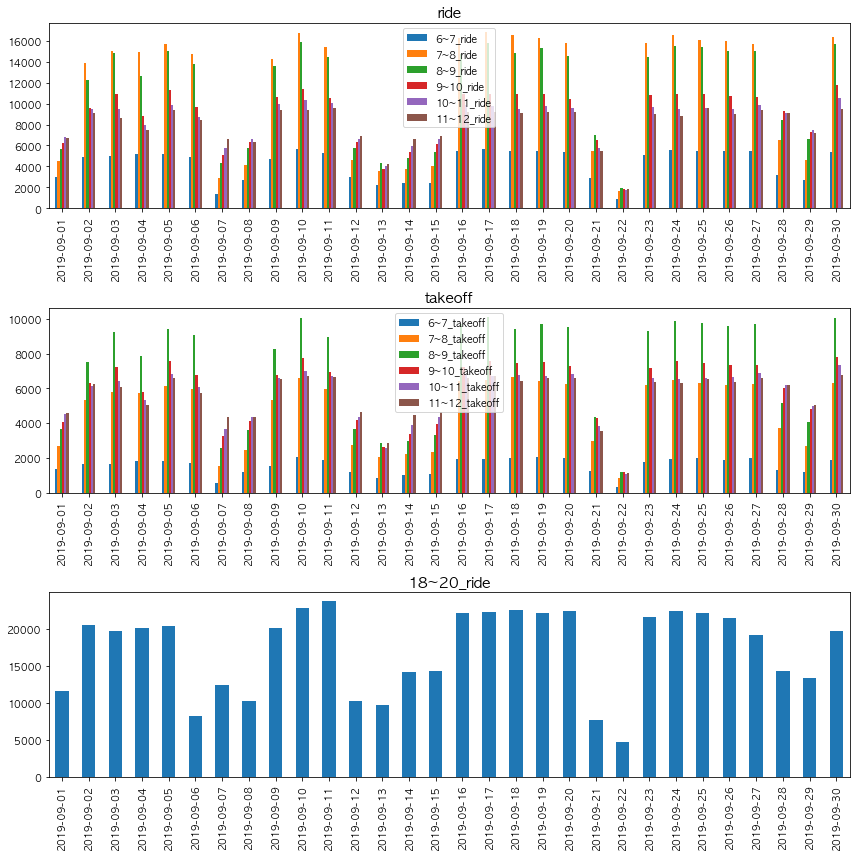

In [10]:
date_sum_ = train.groupby(['date'])[col_t + ['18~20_ride']].sum() # 날짜별 그룹화 후 날짜별로 모든 시간대에 대한 승하차 수의 합계 계산
date_sum_.index = date_sum_.index.date

plt.figure(figsize=(12,12))
ax=plt.subplot(3,1,1)
date_sum_[date_sum_.columns[:6]].plot(kind='bar', ax=ax)
plt.title("ride", fontsize=15)
ax=plt.subplot(3,1,2)
date_sum_[date_sum_.columns[6:-1]].plot(kind='bar', ax=ax)
plt.title("takeoff", fontsize=15)
ax=plt.subplot(3,1,3)
date_sum_[date_sum_.columns[-1]].plot(kind='bar', ax=ax)
plt.title("18~20_ride", fontsize=15)

plt.tight_layout()
plt.show()

* 평일과 주말에 버스 이용율 차이에 대한 패턴이 보인다.
* 요일 변수(category) 또는 평일여부(dummy) 파생변수에 대한 고려가 필요해보임.
* 날짜 별 총 승객수도 고려할 필요 있음.

따라서 필요한 추가 고려 변수들 :

요일 (weekday) - 1,2,3,4,5,6,7

평일 여부 (weekend) - 1/0

공휴일 여부 (holiday) - 1/0

### 요일에 따른 버스수요 차이

In [11]:
# 요일 나타내는 weekday 변수 추가
# 월요일 0 일요일 6

train['weekday'] = train['date'].dt.weekday
test['weekday'] = test['date'].dt.weekday

In [13]:
train.groupby('weekday').count().sort_values('18~20_ride', ascending=False)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
weekday,,,,,,,,,,,,,,,,,,,,,
0,77452,77452,77452,77452,77452,77452,77452,77452,77452,77452,...,77452,77452,77452,77452,77452,77452,77452,77452,77452,77452
1,63418,63418,63418,63418,63418,63418,63418,63418,63418,63418,...,63418,63418,63418,63418,63418,63418,63418,63418,63418,63418
2,61784,61784,61784,61784,61784,61784,61784,61784,61784,61784,...,61784,61784,61784,61784,61784,61784,61784,61784,61784,61784
3,58981,58981,58981,58981,58981,58981,58981,58981,58981,58981,...,58981,58981,58981,58981,58981,58981,58981,58981,58981,58981
4,55695,55695,55695,55695,55695,55695,55695,55695,55695,55695,...,55695,55695,55695,55695,55695,55695,55695,55695,55695,55695
6,52506,52506,52506,52506,52506,52506,52506,52506,52506,52506,...,52506,52506,52506,52506,52506,52506,52506,52506,52506,52506
5,45587,45587,45587,45587,45587,45587,45587,45587,45587,45587,...,45587,45587,45587,45587,45587,45587,45587,45587,45587,45587


월,화,수,목,금 순서대로 평일이 18~20 ride의 수가 큼. 그리고 토요일이 가장 적음.

요일이 18~20 ride의 값에 영향을 주는 변수로 고려해 볼 수 있음.

#### <span style="color:red">요일 (weekday) - 1,2,3,4,5,6,7 을 파생변수로 가져가기</span>

### 공휴일여부에 따른 버스 수요의 차이

In [14]:
def get_dayattr(df):
    # 0(Monday) ~ 6(Sunday)
    df['dayofweek'] = df['date'].dt.dayofweek
    # 추석, 한글날, 개천절
    holiday=['2019-09-12', '2019-09-13', '2019-09-14','2019-10-03','2019-10-09']
    df['weekends'] = np.where(df['dayofweek'] >= 5, 1,0) # 주말여부
    df['holiday'] = np.where(df['date'].isin(holiday), 1,0) # 공휴일여부
    return df
train = get_dayattr(train)

In [17]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday,dayofweek,weekends,holiday
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6,6,1,0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,...,0.0,0.0,0.0,0.0,0.0,5.0,6,6,1,0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,2.0,6,6,1,0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,...,0.0,0.0,0.0,0.0,0.0,53.0,6,6,1,0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,6,6,1,0


In [18]:
holiday_0 = train.query('holiday=="0"').reset_index()
holiday_1 = train.query('holiday=="1"').reset_index()

holiday_0.shape, holiday_1.shape

((384704, 26), (30719, 26))

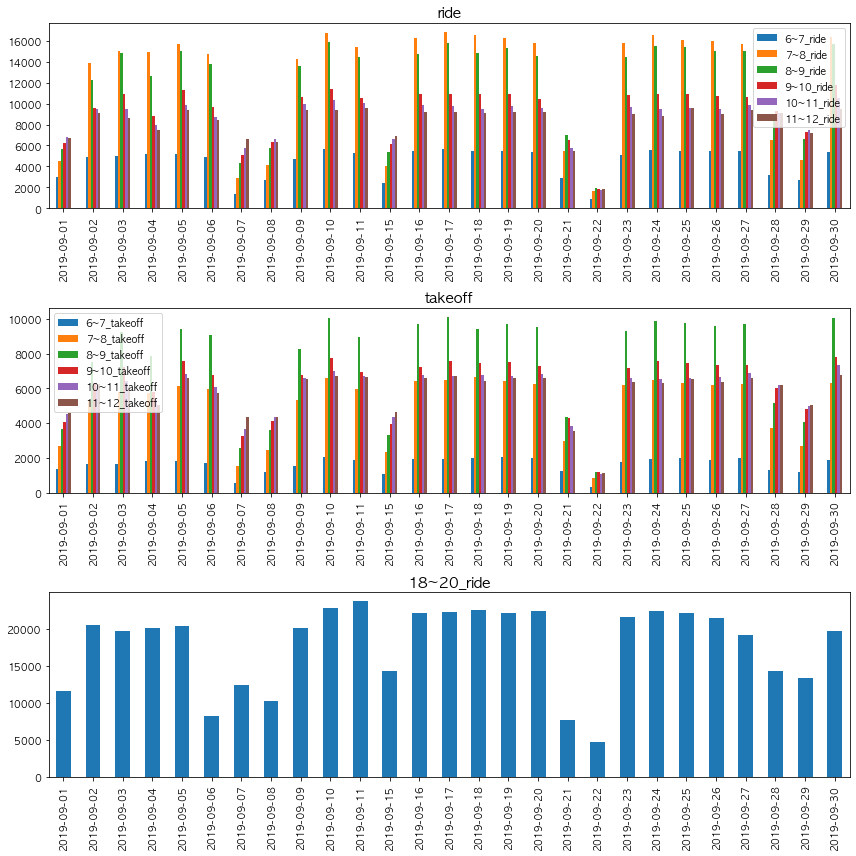

In [19]:
# not holiday
holiday_0_date_sum_ = holiday_0.groupby(['date'])[col_t + ['18~20_ride']].sum() # 날짜별 그룹화 후 날짜별로 모든 시간대에 대한 승하차 수의 합계 계산
holiday_0_date_sum_.index = holiday_0_date_sum_.index.date

plt.figure(figsize=(12,12))
ax=plt.subplot(3,1,1)
holiday_0_date_sum_[holiday_0_date_sum_.columns[:6]].plot(kind='bar', ax=ax)
plt.title("ride", fontsize=15)
ax=plt.subplot(3,1,2)
holiday_0_date_sum_[holiday_0_date_sum_.columns[6:-1]].plot(kind='bar', ax=ax)
plt.title("takeoff", fontsize=15)
ax=plt.subplot(3,1,3)
holiday_0_date_sum_[holiday_0_date_sum_.columns[-1]].plot(kind='bar', ax=ax)
plt.title("18~20_ride", fontsize=15)

plt.tight_layout()
plt.show()

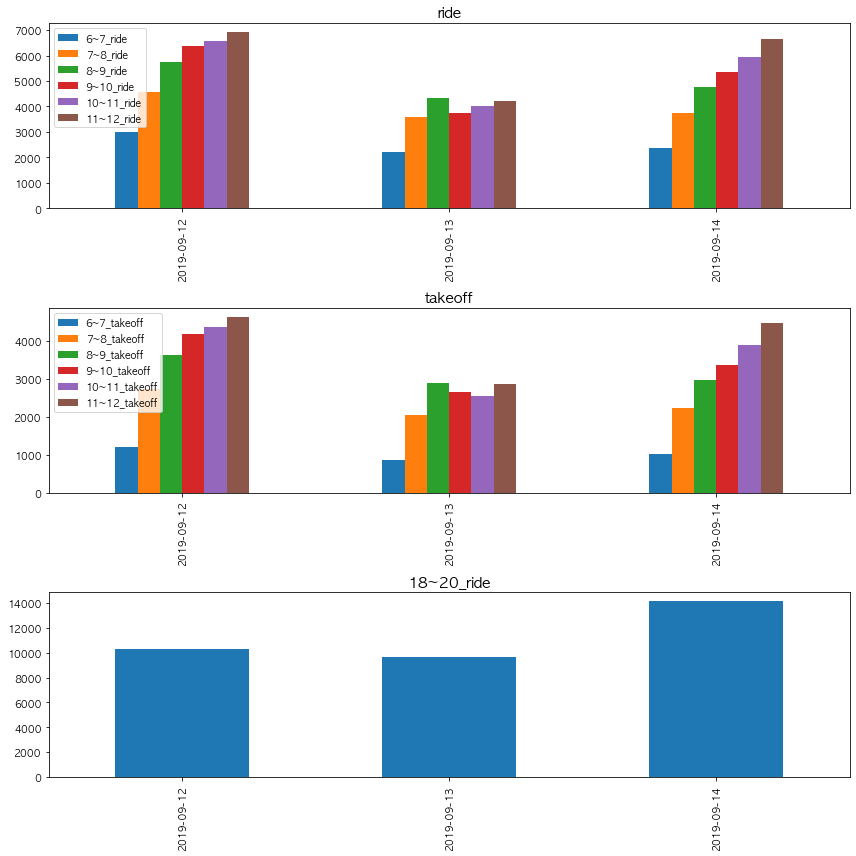

In [20]:
# holiday
holiday_1_date_sum_ = holiday_1.groupby(['date'])[col_t + ['18~20_ride']].sum() # 날짜별 그룹화 후 날짜별로 모든 시간대에 대한 승하차 수의 합계 계산
holiday_1_date_sum_.index = holiday_1_date_sum_.index.date

plt.figure(figsize=(12,12))
ax=plt.subplot(3,1,1)
holiday_1_date_sum_[holiday_1_date_sum_.columns[:6]].plot(kind='bar', ax=ax)
plt.title("ride", fontsize=15)
ax=plt.subplot(3,1,2)
holiday_1_date_sum_[holiday_1_date_sum_.columns[6:-1]].plot(kind='bar', ax=ax)
plt.title("takeoff", fontsize=15)
ax=plt.subplot(3,1,3)
holiday_1_date_sum_[holiday_1_date_sum_.columns[-1]].plot(kind='bar', ax=ax)
plt.title("18~20_ride", fontsize=15)

plt.tight_layout()
plt.show()

공휴일이 아닌 경우 :
* 승차는 7-8, 8-9 시간대가 가장 많음
* 하차는 8-9, 9-10 시간대가 가장 많음

공휴일인 경우 : 공휴일이 아닌 날짜와는 다른 패턴을 보임
* 승차 10-11, 11-12 시간대가 많음
* 하차 10-11, 11-12 시간대가 많음

공휴일이 아닌 경우는 아마 출근시간대에 영향을 받기 때문이며, 공휴일인 경우 출근을 하지 않기 때문에 유동시간이 점심시간 전 늦은 오전 시간대인 것으로 추정해볼 수 있음.

따라서 공휴일에 따른 유동시간대의 변화 차이가 존재한다고 볼 수 있음.

#### <span style="color:red"> 공휴일여부(holiday) - 1/0 을 파생변수로 가져가기</span>

### 주말여부에 따른 버스 수요의 차이

In [21]:
weekends_0 = train.query('weekends=="0"').reset_index()
weekends_1 = train.query('weekends=="1"').reset_index()

weekends_0.shape, weekends_1.shape

((317330, 26), (98093, 26))

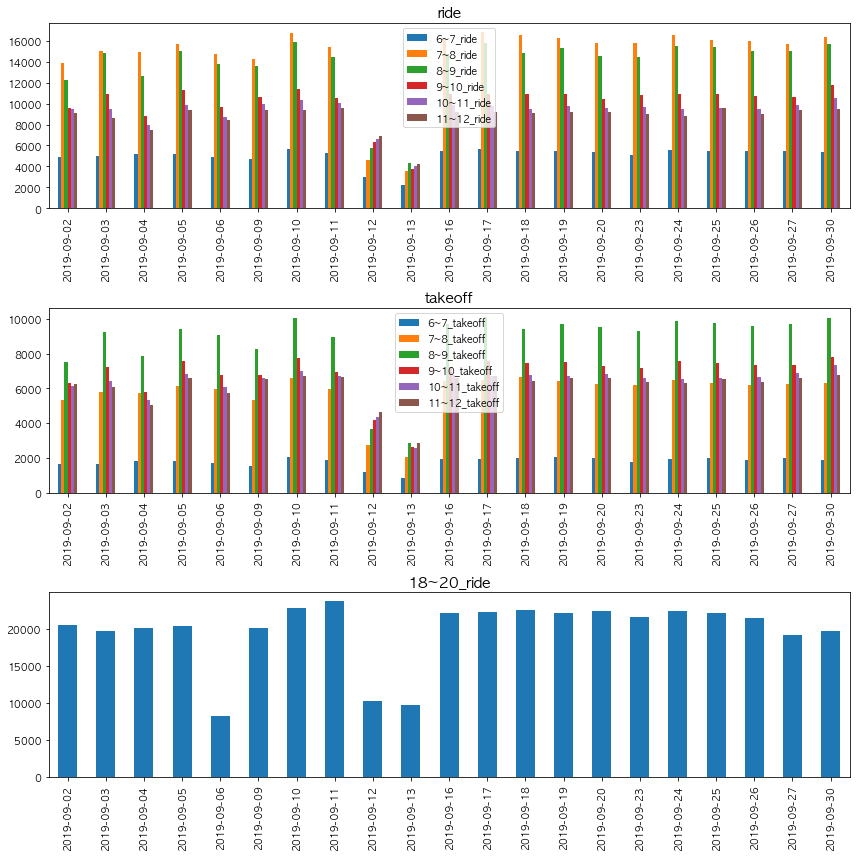

In [22]:
# weekends == 0
weekends_0_date_sum_ = weekends_0.groupby(['date'])[col_t + ['18~20_ride']].sum() # 날짜별 그룹화 후 날짜별로 모든 시간대에 대한 승하차 수의 합계 계산
weekends_0_date_sum_.index = weekends_0_date_sum_.index.date

plt.figure(figsize=(12,12))
ax=plt.subplot(3,1,1)
weekends_0_date_sum_[weekends_0_date_sum_.columns[:6]].plot(kind='bar', ax=ax)
plt.title("ride", fontsize=15)
ax=plt.subplot(3,1,2)
weekends_0_date_sum_[weekends_0_date_sum_.columns[6:-1]].plot(kind='bar', ax=ax)
plt.title("takeoff", fontsize=15)
ax=plt.subplot(3,1,3)
weekends_0_date_sum_[weekends_0_date_sum_.columns[-1]].plot(kind='bar', ax=ax)
plt.title("18~20_ride", fontsize=15)

plt.tight_layout()
plt.show()

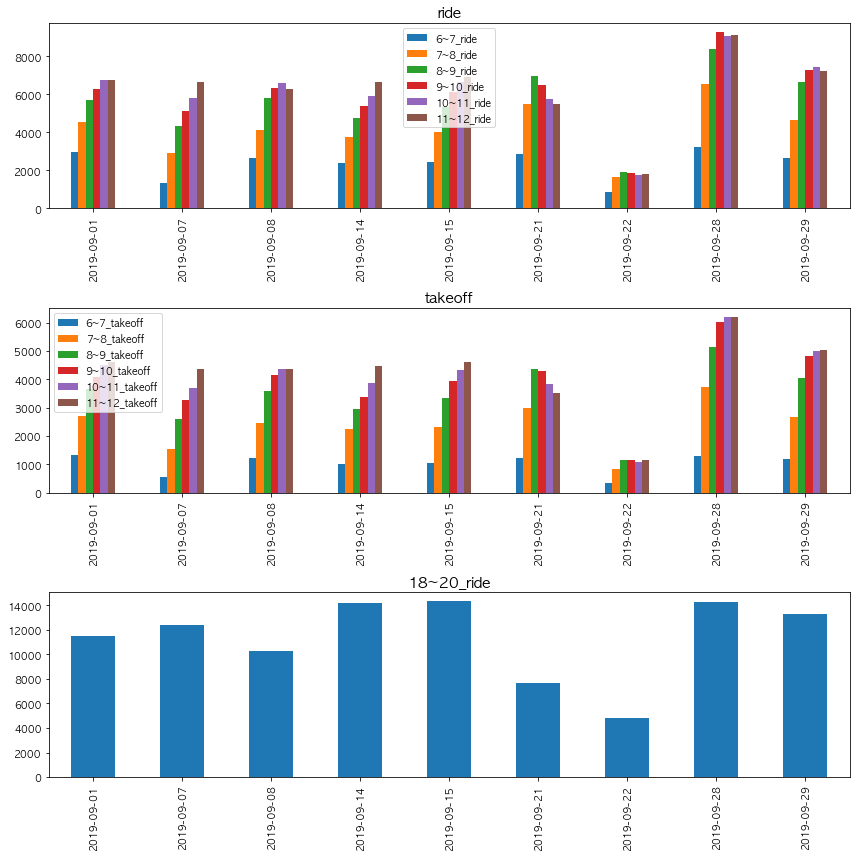

In [23]:
# weekends == 1
weekends_1_date_sum_ = weekends_1.groupby(['date'])[col_t + ['18~20_ride']].sum() # 날짜별 그룹화 후 날짜별로 모든 시간대에 대한 승하차 수의 합계 계산
weekends_1_date_sum_.index = weekends_1_date_sum_.index.date

plt.figure(figsize=(12,12))
ax=plt.subplot(3,1,1)
weekends_1_date_sum_[weekends_1_date_sum_.columns[:6]].plot(kind='bar', ax=ax)
plt.title("ride", fontsize=15)
ax=plt.subplot(3,1,2)
weekends_1_date_sum_[weekends_1_date_sum_.columns[6:-1]].plot(kind='bar', ax=ax)
plt.title("takeoff", fontsize=15)
ax=plt.subplot(3,1,3)
weekends_1_date_sum_[weekends_1_date_sum_.columns[-1]].plot(kind='bar', ax=ax)
plt.title("18~20_ride", fontsize=15)

plt.tight_layout()
plt.show()

평일인 경우 :
* 승차는 7-8, 8-9 시간대가 가장 많음
* 하차는 8-9, 9-10 시간대가 가장 많음

주말인 경우 :
* 승차 10-11, 11-12 시간대가 많음
* 하차 10-11, 11-12 시간대가 많음

주말은 평일과 다르게 출근시간대에 영향을 덜 받기 때문에 유동시간이 비교적 늦은 오전 시간대인 것으로 추정해볼 수 있음.

따라서 주말 여부에 따른 유동시간대의 변화 차이가 존재한다고 볼 수 있음.

#### <span style="color:red"> 주말여부(weekends) - 1/0 을 파생변수로 가져가기</span>

### 출근시간 총 승객수

In [43]:
train['ride_sum'] = train['6~7_ride'] + train['7~8_ride'] + train['8~9_ride'] + train['9~10_ride'] + train['10~11_ride'] + train['11~12_ride'] 
train['takeoff_sum'] = train['6~7_takeoff'] + train['7~8_takeoff'] + train['8~9_takeoff'] + train['9~10_takeoff'] + train['10~11_takeoff'] + train['11~12_takeoff'] 

In [51]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday,dayofweek,weekends,holiday,ride_sum,takeoff_sum
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,...,0.0,0.0,0.0,0.0,6,6,1,0,16.0,0.0
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,...,0.0,0.0,0.0,5.0,6,6,1,0,22.0,0.0
2,2,2019-09-01,4270000,1,432,정존마을,33.48181,126.47352,1.0,1.0,...,0.0,0.0,0.0,2.0,6,6,1,0,4.0,0.0
3,3,2019-09-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,...,0.0,0.0,0.0,53.0,6,6,1,0,79.0,0.0
4,4,2019-09-01,4270000,0,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,...,1.0,0.0,0.0,0.0,6,6,1,0,0.0,1.0


In [56]:
ride_sum_ = train.groupby(['date'])['ride_sum'].sum()
takeoff_sum_ = train.groupby(['date'])['takeoff_sum'].sum()

In [57]:
ride_sum_.head()

date
2019-09-01    32922.0
2019-09-02    59176.0
2019-09-03    63864.0
2019-09-04    57057.0
2019-09-05    66328.0
Name: ride_sum, dtype: float64

In [58]:
takeoff_sum_.head()

date
2019-09-01    20918.0
2019-09-02    33258.0
2019-09-03    36537.0
2019-09-04    31594.0
2019-09-05    38412.0
Name: takeoff_sum, dtype: float64

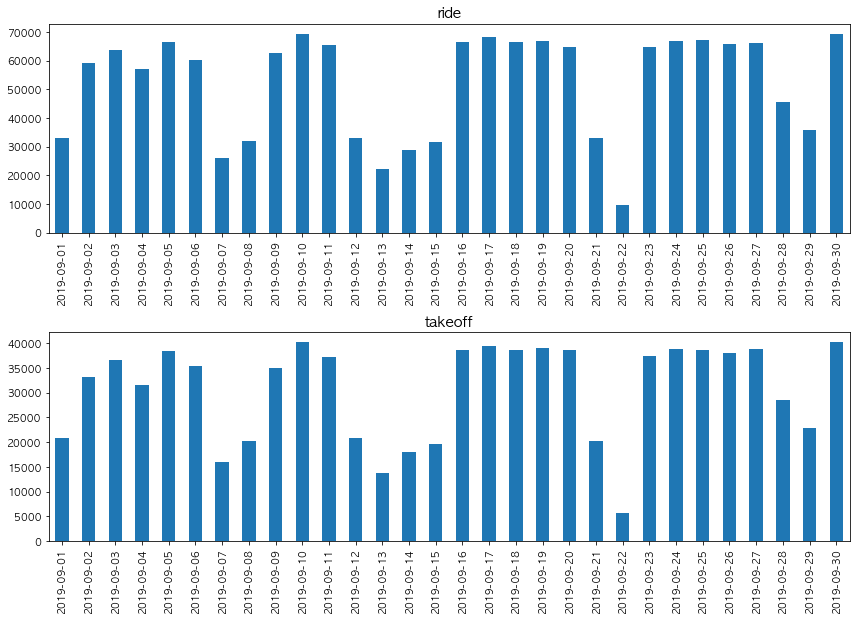

In [60]:
ride_sum_ = train.groupby(['date'])['ride_sum'].sum()
ride_sum_.index = ride_sum_.index.date

takeoff_sum_ = train.groupby(['date'])['takeoff_sum'].sum()
takeoff_sum_.index = takeoff_sum_.index.date

plt.figure(figsize=(12,12))
ax=plt.subplot(3,1,1)
ride_sum_.plot(kind='bar', ax=ax)
plt.title("ride", fontsize=15)

ax=plt.subplot(3,1,2)
takeoff_sum_.plot(kind='bar', ax=ax)
plt.title("takeoff", fontsize=15)

plt.tight_layout()
plt.show()

날짜별 출근시간대 총 승차 승객수, 하차 승객수도 특정 패턴을 보임. (주말 여부에 따른 영향 있다고 봄)

그리고 출근시간대 총 승차 승객수가 하차 승객수보다 많은 경향을 보임. (하차태그를 안찍고 내리는 영향을 받았을수도)

#### <span style="color:red"> 출근시간 총 승차승객수(ride_sum)와 출근시간 총 하차승객수(takeoff_sum)를 파생변수로 가져가기</span>

### 날짜별 각 시간대의 총 승객수

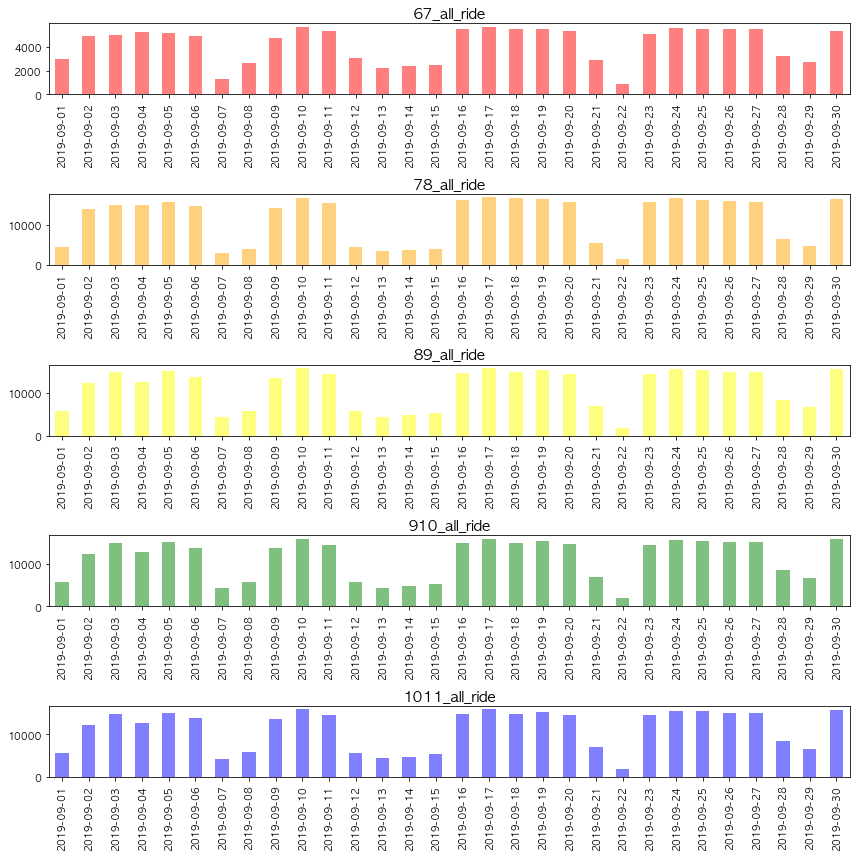

In [103]:
# 날짜별 각 시간대의 총 승객수

all_ride_67 = train.groupby(['date'])['6~7_ride'].sum()
all_ride_67.index = all_ride_67.index.date

all_ride_78 = train.groupby(['date'])['7~8_ride'].sum()
all_ride_78.index = all_ride_78.index.date

all_ride_89 = train.groupby(['date'])['8~9_ride'].sum()
all_ride_89.index = all_ride_89.index.date

all_ride_910 = train.groupby(['date'])['9~10_ride'].sum()
all_ride_910.index = all_ride_910.index.date

all_ride_1011 = train.groupby(['date'])['10~11_ride'].sum()
all_ride_1011.index = all_ride_1011.index.date

plt.figure(figsize=(12,12))
ax=plt.subplot(5,1,1)
all_ride_67.plot(kind='bar', ax=ax, color='red', alpha=0.5)
plt.title("67_all_ride", fontsize=15)

ax=plt.subplot(5,1,2)
all_ride_78.plot(kind='bar', ax=ax, color='orange', alpha=0.5)
plt.title("78_all_ride", fontsize=15)

ax=plt.subplot(5,1,3)
all_ride_89.plot(kind='bar', ax=ax, color='yellow', alpha=0.5)
plt.title("89_all_ride", fontsize=15)

ax=plt.subplot(5,1,4)
all_ride_89.plot(kind='bar', ax=ax, color='green', alpha=0.5)
plt.title("910_all_ride", fontsize=15)

ax=plt.subplot(5,1,5)
all_ride_89.plot(kind='bar', ax=ax, color='blue', alpha=0.5)
plt.title("1011_all_ride", fontsize=15)

plt.tight_layout()
plt.show()

날짜별 각 시간대마다의 총 승객수 차이가 조금씩 있음.

In [70]:
# 시각화 더 예쁘게 하기 위해 데이터프레임 합치기

all_ride_ = pd.concat([all_ride_67, all_ride_78, all_ride_89, all_ride_910, all_ride_1011], axis=1)

all_ride_.head()

,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride
2019-09-01,2942.0,4518.0,5682.0,6275.0,6774.0
2019-09-02,4915.0,13853.0,12266.0,9578.0,9444.0
2019-09-03,4991.0,15024.0,14844.0,10912.0,9439.0
2019-09-04,5206.0,14944.0,12620.0,8852.0,7947.0
2019-09-05,5152.0,15661.0,15049.0,11282.0,9833.0


In [71]:
all_ride_.index

Index([2019-09-01, 2019-09-02, 2019-09-03, 2019-09-04, 2019-09-05, 2019-09-06,
       2019-09-07, 2019-09-08, 2019-09-09, 2019-09-10, 2019-09-11, 2019-09-12,
       2019-09-13, 2019-09-14, 2019-09-15, 2019-09-16, 2019-09-17, 2019-09-18,
       2019-09-19, 2019-09-20, 2019-09-21, 2019-09-22, 2019-09-23, 2019-09-24,
       2019-09-25, 2019-09-26, 2019-09-27, 2019-09-28, 2019-09-29, 2019-09-30],
      dtype='object')

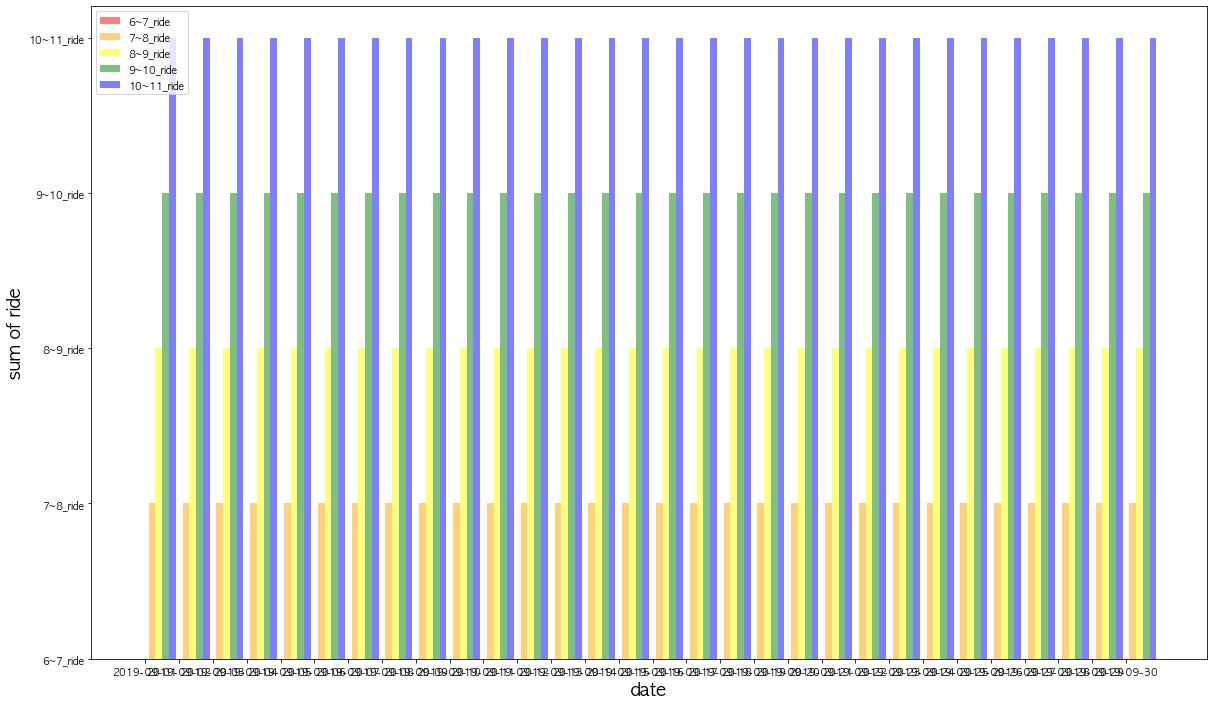

In [101]:
label = all_ride_.index
index = np.arange(len(label))

bar_width = 0.2
alpha = 0.5

plt.figure(figsize=(20,12))

p1 = plt.bar(index + 0, '6~7_ride', 
             bar_width, 
             color='red', 
             alpha=alpha,
             label='6~7_ride')


p2 = plt.bar(index + 0.2, '7~8_ride', 
             bar_width, 
             color='orange', 
             alpha=alpha,
             label='7~8_ride')

p3 = plt.bar(index + 0.4, '8~9_ride', 
             bar_width, 
             color='yellow', 
             alpha=alpha,
             label='8~9_ride')

p4 = plt.bar(index + 0.6, '9~10_ride', 
             bar_width, 
             color='green', 
             alpha=alpha,
             label='9~10_ride')

p5 = plt.bar(index + 0.8, '10~11_ride', 
             bar_width, 
             color='blue', 
             alpha=alpha,
             label='10~11_ride')

plt.ylabel('sum of ride', fontsize=18)

plt.xlabel('date', fontsize=18)

plt.xticks(index, label, fontsize=10)

plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ('6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride', '10~11_ride'), fontsize=10)

plt.show()

#### <span style="color:red"> 날짜별 각 시간대의 총 승객수도 파생변수로 가져가기 : 6-7_all_ride_number, 7-8_all_ride_number, ...</span>

### in_out (시외, 시내) 비교

In [24]:
train['in_out'] = train['in_out'].map({'시내':0,'시외':1})
test['in_out'] = test['in_out'].map({'시내':0,'시외':1})

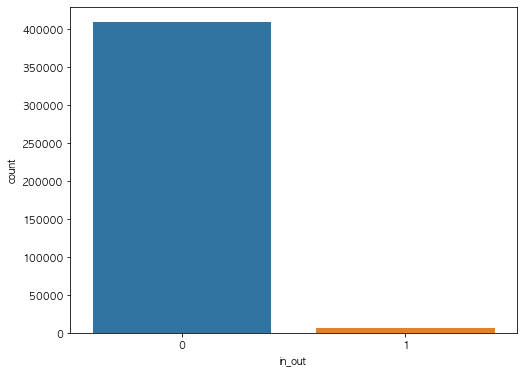

In [25]:
f, ax = plt.subplots(figsize = (8,6))
sns.countplot(train['in_out'])
plt.show()

시외보다 시내에 위치한 정류장에서의 정보가 훨씬 더 많음

In [26]:
#시내
train_in = train[train['in_out'] == 0]

#시외
train_out = train[train['in_out'] == 1]

In [27]:
train_in.sort_values('18~20_ride', ascending=False).head(30)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday,dayofweek,weekends,holiday
190528,190528,2019-09-15,23620000,0,638,제주국제공항(구제주방면),33.50661,126.49345,3.0,31.0,...,14.0,20.0,11.0,8.0,8.0,272.0,6,6,1,0
330993,330993,2019-09-25,23580000,0,201,제주대학교,33.46011,126.56166,4.0,10.0,...,0.0,0.0,6.0,0.0,0.0,265.0,2,2,0,0
46048,46048,2019-09-04,23580000,0,201,제주대학교,33.46011,126.56166,30.0,17.0,...,12.0,0.0,9.0,24.0,2.0,245.0,2,2,0,0
129203,129203,2019-09-10,23580000,0,201,제주대학교,33.46011,126.56166,4.0,5.0,...,0.0,0.0,1.0,0.0,0.0,241.0,1,1,0,0
234231,234231,2019-09-18,23580000,0,201,제주대학교,33.46011,126.56166,0.0,4.0,...,0.0,11.0,0.0,0.0,1.0,240.0,2,2,0,0
113729,113729,2019-09-09,23580000,0,201,제주대학교,33.46011,126.56166,2.0,11.0,...,0.0,5.0,0.0,0.0,0.0,229.0,0,0,0,0
202642,202642,2019-09-16,23620000,0,443,제주한라대학교,33.47833,126.47512,1.0,9.0,...,0.0,0.0,0.0,0.0,0.0,227.0,0,0,0,0
299328,299328,2019-09-23,23580000,0,201,제주대학교,33.46011,126.56166,4.0,3.0,...,0.0,6.0,0.0,1.0,2.0,226.0,0,0,0,0
60972,60972,2019-09-05,23580000,0,201,제주대학교,33.46011,126.56166,2.0,4.0,...,0.0,6.0,0.0,5.0,4.0,218.0,3,3,0,0
202513,202513,2019-09-16,23580000,0,201,제주대학교,33.46011,126.56166,2.0,12.0,...,0.0,0.0,1.0,2.0,0.0,215.0,0,0,0,0


In [28]:
train_out.sort_values('18~20_ride', ascending=False).head(30)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday,dayofweek,weekends,holiday
151099,151099,2019-09-11,29210000,1,357,한라병원,33.48944,126.48508,4.0,14.0,...,0.0,3.0,0.0,2.0,0.0,42.0,2,2,0,0
126450,126450,2019-09-10,22540000,1,357,한라병원,33.48944,126.48508,13.0,4.0,...,1.0,6.0,1.0,1.0,1.0,38.0,1,1,0,0
67202,67202,2019-09-05,29210000,1,357,한라병원,33.48944,126.48508,9.0,8.0,...,1.0,0.0,0.0,1.0,2.0,38.0,3,3,0,0
299008,299008,2019-09-23,23500000,1,357,한라병원,33.48944,126.48508,0.0,1.0,...,1.0,9.0,7.0,3.0,0.0,37.0,0,0,0,0
305460,305460,2019-09-23,29210000,1,357,한라병원,33.48944,126.48508,6.0,10.0,...,3.0,5.0,0.0,1.0,0.0,37.0,0,0,0,0
60644,60644,2019-09-05,23500000,1,357,한라병원,33.48944,126.48508,0.0,2.0,...,1.0,16.0,9.0,1.0,3.0,37.0,3,3,0,0
403534,403534,2019-09-30,23500000,1,357,한라병원,33.48944,126.48508,0.0,1.0,...,1.0,16.0,5.0,5.0,6.0,36.0,0,0,0,0
142390,142390,2019-09-11,22540000,1,357,한라병원,33.48944,126.48508,8.0,5.0,...,1.0,3.0,0.0,0.0,0.0,35.0,2,2,0,0
183896,183896,2019-09-14,29210000,1,357,한라병원,33.48944,126.48508,4.0,15.0,...,1.0,0.0,0.0,1.0,0.0,35.0,5,5,1,1
353064,353064,2019-09-26,29210000,1,357,한라병원,33.48944,126.48508,6.0,10.0,...,0.0,4.0,0.0,2.0,1.0,35.0,3,3,0,0


* 18~20_ride의 값들은 시내 정류소들이 시외 정류소들보다 훨씬 큼.
* 시내에서 18~20_ride의 수가 큰 값을 취하는 정류소들은 공항, 대학교가 많음. 
* 시외에서 18~20_ride의 수가 큰 값을 취하는 정류소들은 대부분 병원임. (종종 제주국제컨벤션센터처럼 행사 진행하는 시설도 보임)

시내 / 시외에 따라 18~20_ride 값이 큰 정류소들의 특징에 차이가 존재한다고 볼 수 있음.

#### <span style="color:red"> 시내/시외(in/out) - 1/0 을 파생변수로 가져가기</span>

### bus_route_id에 따른 승차수 차이

In [38]:
bus_route_id_sum = train.groupby(['bus_route_id'])['18~20_ride'].sum()

bus_route_id_sum

bus_route_id
4270000     2409.0
4280000     1952.0
7990000        0.0
8170000     1747.0
8180000      566.0
17010000       4.0
20010000     185.0
20040000       1.0
20050000       0.0
21000000    2352.0
21010000    2136.0
21020000       0.0
21040000       0.0
21070000       0.0
21080000    1199.0
21090000     626.0
21100000     692.0
21110000     436.0
21120000       0.0
21150000       0.0
21160000       0.0
21180000     541.0
21200000       0.0
21220000     625.0
21230000     691.0
21270000     628.0
21290000     932.0
21300000     406.0
21310000       0.0
21330000       0.0
             ...  
32400000     518.0
32420000       0.0
32460000     175.0
32470000     226.0
32480000     286.0
32490000     730.0
32500000     235.0
32510000       0.0
32520000       0.0
32550000       0.0
32560000       0.0
32570000     345.0
32580000       0.0
32590000     570.0
32610000     156.0
32620000     345.0
32630000      91.0
32640000     301.0
32660000     179.0
32670000      34.0
32680000      35.0

In [40]:
# 위의 표를 데이터프레임화
df = pd.DataFrame(bus_route_id_sum)
df.head()

,18~20_ride
bus_route_id,
4270000,2409.0
4280000,1952.0
7990000,0.0
8170000,1747.0
8180000,566.0


In [41]:
df.sort_values('18~20_ride', ascending=False) # 내림차순 정렬

,18~20_ride
bus_route_id,
23610000,19734.0
23620000,19494.0
23580000,16828.0
23570000,15476.0
22530000,10918.0
22520000,10278.0
25000000,9465.0
25010000,8184.0
23000000,7710.0


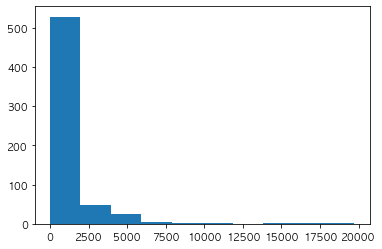

In [42]:
# 그룹화된 bus_route_id에 따른 18~20_ride 분포 시각화
plt.hist(df['18~20_ride'])
plt.show()

bus_route_id에 따라 18~20_ride 값에 차이가 있는 것을 알 수 있음. (bus_route_id에 따른 승차수 차이는 존재)

따라서 bus_route_id 별 18~20_ride 값이 큰 경우를 혼잡도로 생각해 볼 수 있음.

혼잡도를 나눌 기준을 세운 후 그에 따른 레벨을 정해주어 혼잡도(congestion) 파생변수 생성을 고려해 볼 필요 있음.

#### <span style="color:red"> 혼잡도(congestion)를 파생변수로 가져가기</span>